---
title: "Midterm exam 2025, Classification Problem"
subtitle: "Machine Learning"
date: "February 2025"
date-format: "MMMM YYYY"
author: 
  - F.San Segundo & N.Rodríguez
code-overflow: wrap
format: 
  html: 
    toc: true
    code-tools: true
    code-fold: show
    code-summary: "Hide the code"
    embed-resources: true
---

In [1]:
%cd ./00_previous_exams/Midterm2025

/wd/00_previous_exams/Midterm2025



<h1 style="color:red;">Instructions: Read Carefully!</h1>


- **[Use this Jupyter notebook]{.underline}** to complete the required tasks and submit it to Moodle. Keep the sectioning structure of the notebook and insert the code cells you need in the corresponding sections.

- The notebook should contain the code with your **analysis** and **it must be reproducible**. Set the random seeds to ensure that.

- The **most important part of your work is the comments and interpretation** of the analysis results obtained. **Do not include uncommented figures**. Remember to include a **conclusion section** at the end.                          

- **[Use OBS to record your screen]{.underline}**. Upload the video file (max. 500Mb) to Moodle. Alternatively, make sure to copy it to one of the pendrives that will be provided.

- The exam has **two notebooks:** one for the Regression problem (70% of the grading) and this one for the **Classification Problem** (30%). You must submit both of them to Moodle.


## Statement of the Classification Problem

### Dataset 

+ Look for your student code in the `student_codes.txt` file. Use the corresponding zip file cpntaining the data files for your analysis.  
  **IMPORTANT: An exam done with a wrong dataset implies a failed exam.**

+ Load the data set **fdata_cls_XX.csv** corresponding to your student code. Make sure you read it correctly. 

+ The binary target variable is called `cardio`: presence or absence of cardiovascular disease.

+ The dataset contains 11 input variables:
  + Age (years, as float)
  + Gender (Male, Female)
  + Height (cm)
  + Weight (kg)
  + ap_hi (Systolic blood pressure)
  + ap_lo (Diastolic blood pressure)
  + cholesterol (1: normal, 2: above normal, 3: well above normal)
  + gluc (Glucose 1: normal, 2: above normal, 3: well above normal)
  + smoke (Smoking 1: yes, 0: no)
  + alco  (Alcohol intake 1: yes, 0: no)
  + active  (Physical activity 1: yes, 0: no)


### External Code and Imports

+ The first code cell below contains standard imports that we have used in the sessions. With these imports you should be able to do all the tasks in the exam; that is not to say that you need to use all of them, and you are invited to use extra imports if you feel the need.

+ To speed up your worl we **strongly** recommend you to adapt the code in the file `2_4_Performance_Analysis_Binary_Classifier.py` to assess the performance of the classifier models. We have included a copy of the file with the exam files.  We have also included the Python script `auxiliary_code.py` with a function called `explore_outliers` that will be available when you run the second cell in this notebook. 

In [2]:
# %matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Data management libraries
import numpy as np 
import pandas as pd
import scipy.stats as stats

# Scikit transformers and pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Scikit model selection and cross-validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

# Scikit metrics and model performance
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay


# Scikit classifiers
from sklearn.ensemble import RandomForestClassifier


In [3]:
%run -i "auxiliary_code.py"

In [6]:
# Use your student code to select the data files.
df = pd.read_csv("./fdata_cls_01.csv", sep=";")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,58.161644,M,168,59.0,120,80,1,1.0,0.0,0,1.0,NO
1,50.484932,M,160,78.0,120,80,1,1.0,0.0,1,1.0,NO
2,51.238356,M,169,69.0,120,70,1,1.0,0.0,0,1.0,NO
3,45.824658,F,172,66.0,110,70,1,1.0,1.0,0,1.0,NO
4,44.380822,M,172,84.0,125,80,1,1.0,0.0,0,1.0,NO


### 2.1  Exploratory analysis and train/test split of data

+ **Use 20% of the data as test set.**
+ **When performing the split make sure to use `random_state=1` for reproducibility.**

In [7]:
output = "cardio"
df['cardio']=df['cardio'].map({'YES':1, 'NO':0})

In [8]:
df.nunique()

age            1089
gender            2
height           50
weight           81
ap_hi            31
ap_lo            25
cholesterol       3
gluc              3
smoke             2
alco              2
active            2
cardio            2
dtype: int64

We see that `gender` is categorical, as well as `cholesterol`, `gluc`, `smoke`, `alco`, and `active`, despite these being numbers

In [9]:
cat_inputs = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
df[cat_inputs + [output]] = df[cat_inputs + [output]].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          1351 non-null   float64 
 1   gender       1351 non-null   category
 2   height       1351 non-null   int64   
 3   weight       1351 non-null   float64 
 4   ap_hi        1351 non-null   int64   
 5   ap_lo        1351 non-null   int64   
 6   cholesterol  1351 non-null   category
 7   gluc         1325 non-null   category
 8   smoke        1314 non-null   category
 9   alco         1351 non-null   category
 10  active       1338 non-null   category
 11  cardio       1351 non-null   category
dtypes: category(7), float64(2), int64(3)
memory usage: 63.0 KB


In [10]:
inputs = df.columns.drop(output)
num_inputs = inputs.difference(cat_inputs).tolist()
print(inputs)

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active'],
      dtype='object')


Now that we have the numerical and categorical inputs defined, let's check out missing values.

In [11]:
df.isnull().sum(axis=0)

age             0
gender          0
height          0
weight          0
ap_hi           0
ap_lo           0
cholesterol     0
gluc           26
smoke          37
alco            0
active         13
cardio          0
dtype: int64

Since they are not too much compared with the size of the dataset, we opt for deleting them directly:

In [12]:
df.dropna(inplace=True)
df.isnull().sum(axis=0)

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Now, we split into **training and test** sets.

In [13]:
X = df.drop(columns=output)
Y = df[output]

XTR, XTS, YTR, YTS = train_test_split(X, Y,
                                      test_size=0.2,  # percentage preserved as test data
                                      random_state=1, # seed for replication
                                      stratify = Y)   # Preserves distribution of y

Let's check outliers in the numerical inputs:

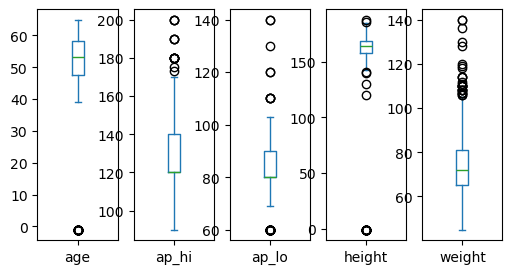

In [14]:
XTR_numeric_boxplots = XTR[num_inputs].plot.box(subplots=True, 
                                            layout=(1, len(num_inputs)), 
                                            sharex=False, sharey=False, figsize=(6, 3))

We see some obvious wrong observations: 

* A negative `age`
* A `height` of 0

Also, we can delete the outliers for `ap_lo`, and `ap_hi`, since they are quite far away from each other. 
Let's first delete the outliers for these variables and re-evaluate the outliers.

{'age': {'values': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1.]), 'positions': [69, 76, 122, 134, 146, 276, 317, 342, 363, 433, 451, 498, 528, 542, 570, 592, 600, 609, 641, 664, 699, 721, 752, 812, 832, 846, 853, 890, 891, 959, 1006, 1013], 'indices': [294, 1189, 402, 1121, 144, 886, 818, 984, 647, 135, 657, 17, 683, 1095, 550, 307, 1314, 602, 206, 1156, 381, 873, 275, 1154, 485, 823, 890, 902, 493, 205, 1294, 980]}, 'height': {'values': array([130,  -1, 140,  -1,  -1,  -1,  -1,  -1,  -1, 120,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1,  -1, 141,  -1,  -1,  -1,  -1,  -1,  -1,
        -1,  -1,  -1,  -1,  -1, 186, 188]), 'positions': [43, 51, 118, 177, 186, 207, 319, 323, 347, 355, 365, 431, 457, 458, 466, 501, 570, 579, 589, 664, 669, 744, 748, 828, 832, 846, 858, 860, 893, 915, 927, 950, 990], 'indices': [601, 963, 863, 1152, 344, 340, 24, 987, 526,

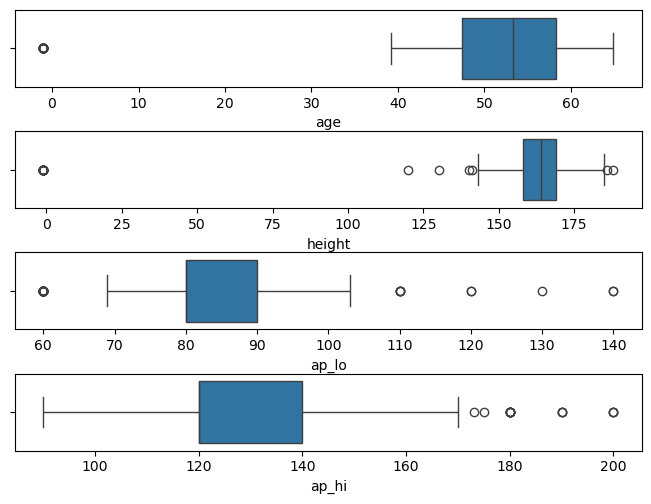

In [15]:
outliers_tr = explore_outliers(XTR, ["age", "height", "ap_lo", "ap_hi"])
print(outliers_tr)

In [16]:
outliers_tr_index = set([k for var in ["age", "height", "ap_lo", "ap_hi"] for k in outliers_tr[var]["indices"]])

XTR.drop(outliers_tr_index, axis=0, inplace=True)
YTR.drop(outliers_tr_index, axis=0, inplace=True)

We can re-evaluate the outliers:

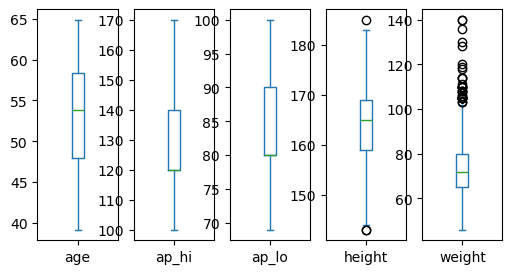

In [17]:
XTR_numeric_boxplots = XTR[num_inputs].plot.box(subplots=True, 
                                            layout=(1, len(num_inputs)), 
                                            sharex=False, sharey=False, figsize=(6, 3))

Although we can see that there are outliers in `weight`, they are quite a few and are very close to the maximum in the sample. Therefore, we opt not to delete them, since intuition tells us that `weight` could be relevant for `cardio`

Now, let's explore the **relation between numerical inputs**

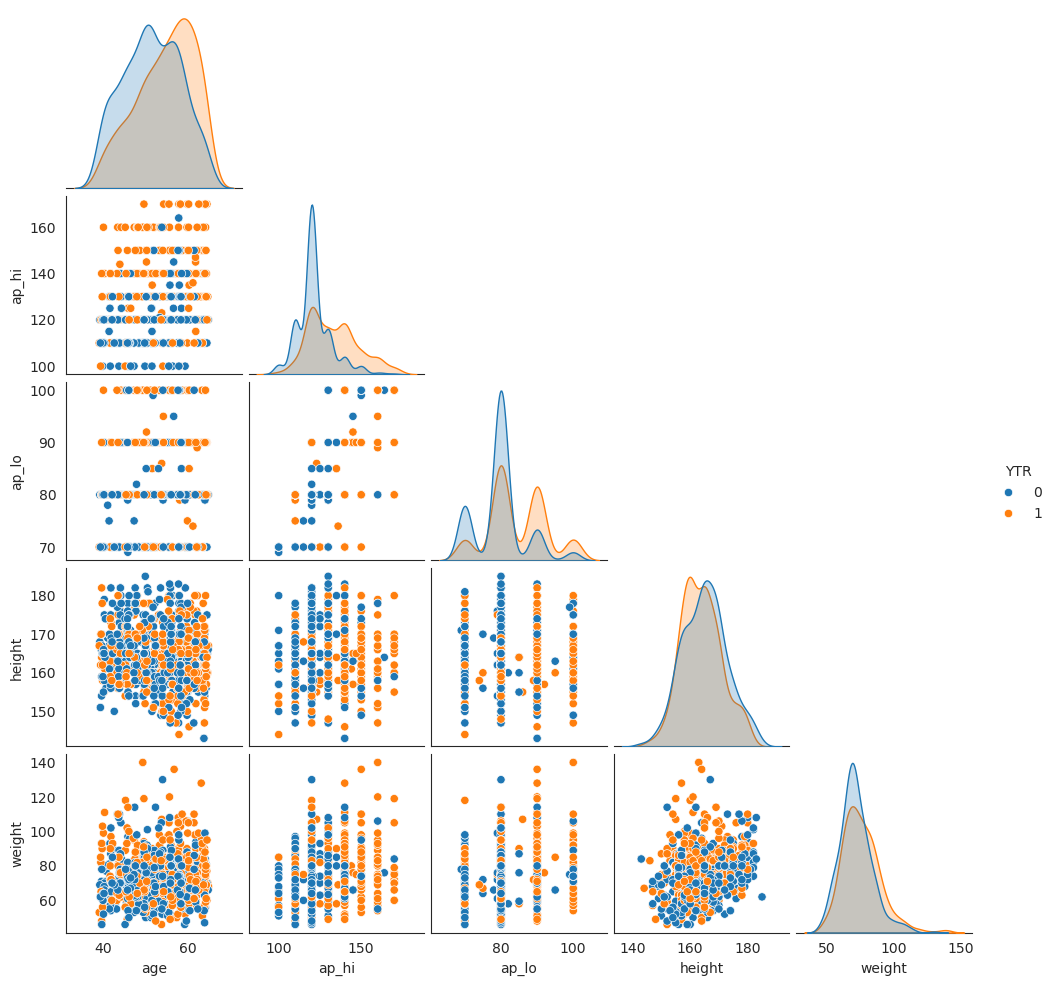

In [18]:
sns.set_style("white")
plt_df = XTR[num_inputs].copy()
plt_df["YTR"] = YTR
sns.pairplot(plt_df, hue="YTR", corner=True, height=2)

* `age` may allow some distinction in the target variable, as "1" is slightly moved to the right. Same with `ap_hi`, and `ap_lo`
* `ap_hi` and `ap_lo` present some linear correlation. However, as we can see in the matrix below, their correlations is 0.75. To delet one of them, it would convenient that the correlation is at least 0.9
* No further relations between numerical inputs can be strongly appreciated with the pairplot.

Let's see the correlation matrix

In [19]:
XTR[num_inputs].corr()

,age,ap_hi,ap_lo,height,weight
age,1.000000,0.249662,0.182141,-0.124046,0.066572
ap_hi,0.249662,1.000000,0.731719,-0.007359,0.264828
ap_lo,0.182141,0.731719,1.000000,0.012211,0.218302
height,-0.124046,-0.007359,0.012211,1.000000,0.229955
weight,0.066572,0.264828,0.218302,0.229955,1.000000


Let's see the relation between **numerical and categorical inputs**

Analyzing the relation between factor inputs and age


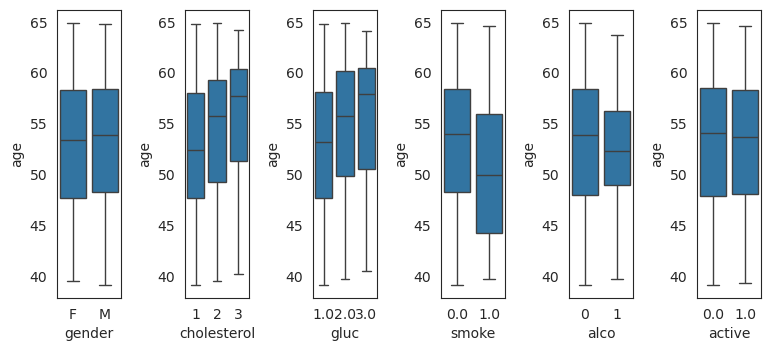

<Figure size 100x100 with 0 Axes>

Analyzing the relation between factor inputs and ap_hi


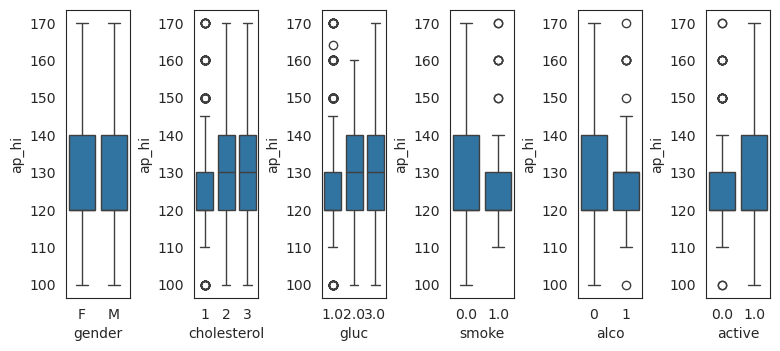

<Figure size 100x100 with 0 Axes>

Analyzing the relation between factor inputs and ap_lo


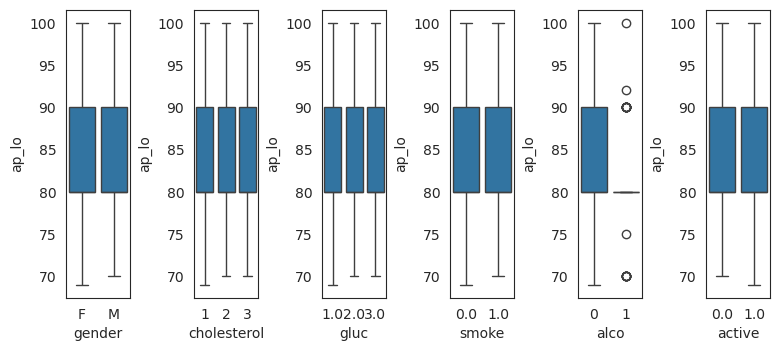

<Figure size 100x100 with 0 Axes>

Analyzing the relation between factor inputs and height


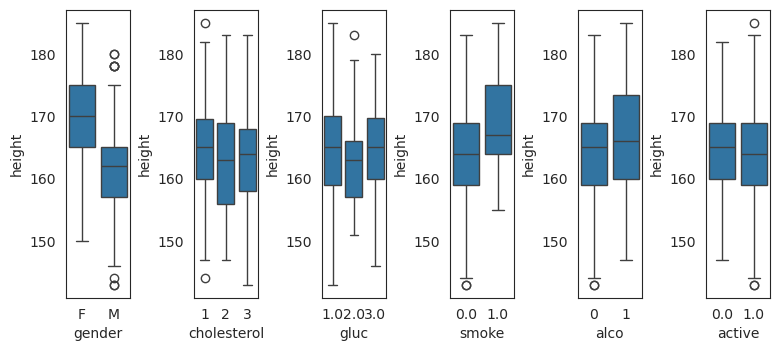

<Figure size 100x100 with 0 Axes>

Analyzing the relation between factor inputs and weight


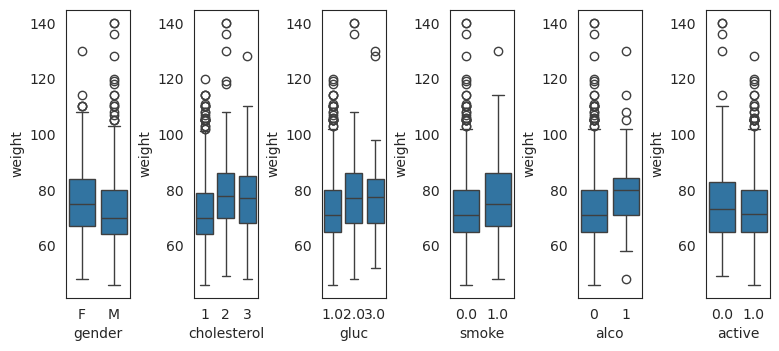

<Figure size 100x100 with 0 Axes>

In [20]:
for numVar in num_inputs: 
    print("Analyzing the relation between factor inputs and", numVar)
    fig, axes = plt.subplots(1, len(cat_inputs))  # create figure and axes
    if len(cat_inputs) == 1:
        axes = [axes]  # Ensure axes is a list even if it contains only one Axes object
    for col, ax in zip(cat_inputs, axes):  # boxplot for each factor input
        sns.boxplot(data=XTR, x=col, y=numVar, ax=ax) 
    # set subplot margins
    plt.subplots_adjust(left=0.9, bottom=0.4, right=2, top=1, wspace=1, hspace=1)
    plt.figure(figsize=(1, 1))
    plt.show()

We see a relation between `gender` and `height`, but the distinction is not perfect. Let's keep it. 

In [21]:
# In case we want to check what happens if we delete ap_hi 

#XTR.drop(columns=['ap_hi'], inplace=True)
#XTS.drop(columns=['ap_hi'], inplace=True)
#num_inputs = list(set(num_inputs) - set(['ap_hi']))
#inputs = cat_inputs + num_inputs

In [22]:
dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

dfTR.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
747,45.923288,M,178,97.0,110,80,1,1.0,0.0,0,1.0,0
491,47.394521,F,175,95.0,160,100,2,1.0,0.0,0,1.0,1
1261,43.501370,M,156,85.0,160,90,1,1.0,0.0,0,1.0,1
392,49.945205,F,173,84.0,120,90,1,1.0,1.0,0,0.0,1
820,51.789041,M,160,60.0,120,70,1,1.0,0.0,0,1.0,0


### 2.2 Random Forest classifier



#### 2.2.1 Model

+ **Train a Random forest classifier for the data. Use grid search to adjust two hyperparameters: minimum samples leaf and the maximum depth.**


We will use grid search for the minimum samples leaf and the maximum depth. We start by defining the pipeline and the grid:

In [23]:
hyp_grid = {'RF__min_samples_leaf':range(6, 10),
            'RF__max_depth': range(6, 10, 1)}

In [24]:
num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

num_transformer.set_output(transform="pandas")
# num_transformer.sparse_output_=False

cat_transformer = Pipeline(
    steps=[("ohe", OneHotEncoder(sparse_output=False))]
)

cat_transformer.set_output(transform="pandas")
# cat_transformer.sparse_output_=False

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_inputs),
        ("cat", cat_transformer, cat_inputs),
    ]
)

preprocessor.set_output(transform="pandas")
# preprocessor.sparse_output_=False

RF_pipe = Pipeline(steps=[('preproc', preprocessor), 
                           ('RF',  RandomForestClassifier(random_state=1, 
                                                          max_features="sqrt", n_estimators=500))]) 

In [25]:
num_folds = 10


RF_gridCV = GridSearchCV(estimator=RF_pipe, 
                        param_grid=hyp_grid, 
                        cv=num_folds,
                        return_train_score=True,
                        n_jobs=-1)

In [26]:
RF_gridCV.fit(XTR, YTR)

,estimator,Pipeline(step...om_state=1))])
,param_grid,"{'RF__max_depth': range(6, 10), 'RF__min_samples_leaf': range(6, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num', ...), ('cat', ...)]"


Let's examine the grid search:

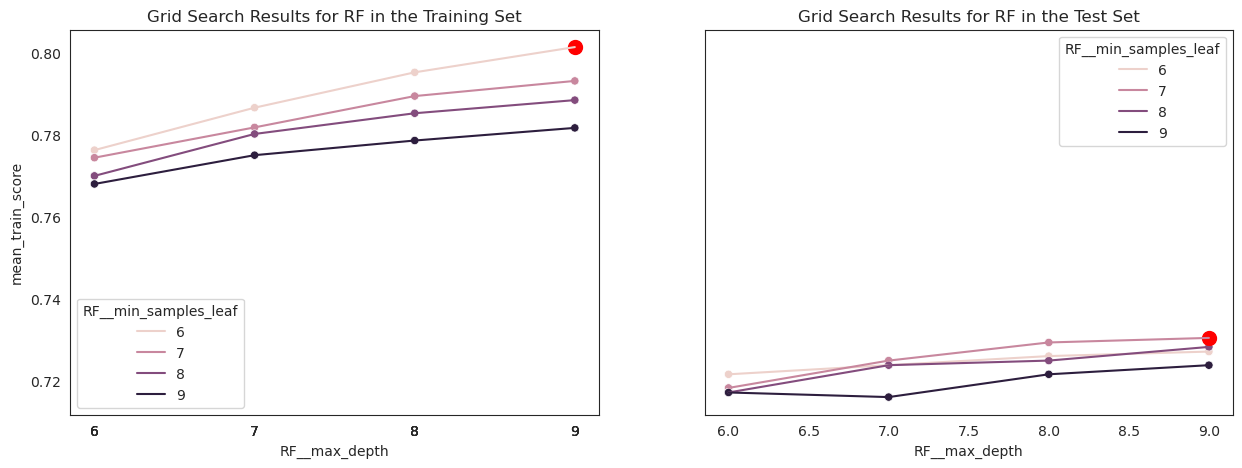

In [28]:
model = RF_gridCV
model_name="RF"
%run -i  "2_5_GridSearch_Plot.py"

It looks like it achieves a good compromise between min samples leaf and maximum depth.

#### 2.2.2 Model Performance

+ **Evaluate its performance using appropriate metrics and plots.** 

Let's start by comparing the training and test scores:

In [29]:
model_train_score = model.score(XTR, YTR), 
model_test_score =  model.score(XTS, YTS)

model_train_score, model_test_score

((0.7993348115299335,), 0.7450980392156863)

The score of the model for both thaining and test is quite low. The difference between training and test shows that the model is not generalizing well to new unobserved data, but there is not overfitting, since the training score is also low.

In [30]:
dfTR_eval = XTR.copy()
dfTR_eval['Y'] = YTR 

dfTS_eval = XTS.copy()
dfTS_eval['Y'] = YTS 

newCol = 'Y_'+ model_name +'_prob_neg'; 
dfTR_eval[newCol] = model.predict_proba(XTR)[:, 0]
newCol = 'Y_'+ model_name +'_prob_pos'; 
dfTR_eval[newCol] = model.predict_proba(XTR)[:, 1]
newCol = 'Y_'+ model_name +'_pred'; 
dfTR_eval[newCol] = model.predict(XTR)

newCol = 'Y_'+ model_name +'_prob_neg'; 
dfTS_eval[newCol] = model.predict_proba(XTS)[:, 0]
newCol = 'Y_'+ model_name +'_prob_pos'; 
dfTS_eval[newCol] = model.predict_proba(XTS)[:, 1]
newCol = 'Y_'+ model_name +'_pred'; 
dfTS_eval[newCol] = model.predict(XTS)


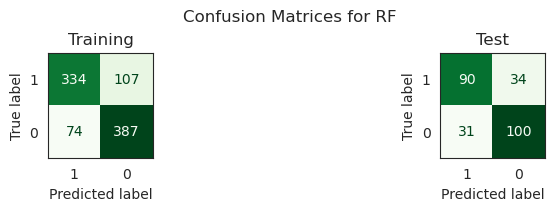

In [31]:
fig = plt.figure(constrained_layout=True, figsize=(6, 2))
spec = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training'); ax1.grid(False)
ax2 = fig.add_subplot(spec[0, 2]);ax2.set_title('Test'); ax2.grid(False)
ConfusionMatrixDisplay.from_estimator(model, XTR, YTR, cmap="Greens", colorbar=False, ax=ax1, labels=[1, 0])
ConfusionMatrixDisplay.from_estimator(model, XTS, YTS, cmap="Greens", colorbar=False, ax=ax2, labels=[1, 0])
plt.suptitle("Confusion Matrices for "+ model_name)
plt.show(); 

The model is missclassifying the "1"s more than the "0"s.

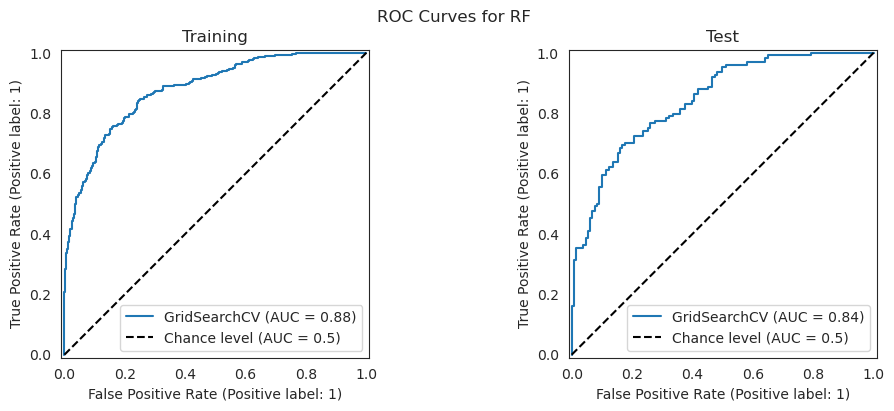

In [32]:
fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training')
ax2 = fig.add_subplot(spec[0, 1]);ax2.set_title('Test')
RocCurveDisplay.from_estimator(model, XTR, YTR, plot_chance_level=True, ax=ax1)
RocCurveDisplay.from_estimator(model, XTS, YTS, plot_chance_level=True, ax=ax2);
plt.suptitle("ROC Curves for "+ model_name)
plt.show();

The ROC curves show that the model is not able to distinguish well between the two classes, much worse in the test set.

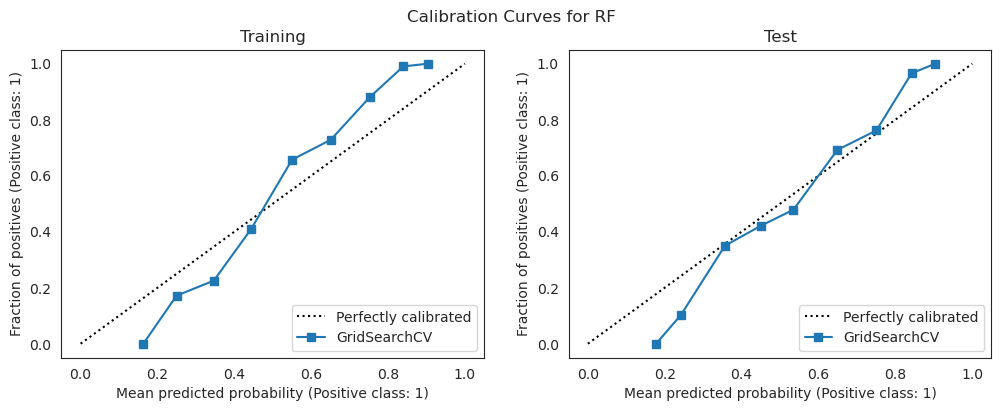

In [33]:

fig = plt.figure(figsize=(12, 4))
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0]);ax1.set_title('Training')
ax2 = fig.add_subplot(spec[0, 1]);ax2.set_title('Test')
CalibrationDisplay.from_estimator(model, XTR, YTR, n_bins=10, ax=ax1)
CalibrationDisplay.from_estimator(model, XTS, YTS, n_bins=10, ax=ax2);
plt.suptitle("Calibration Curves for "+ model_name)
plt.show(); plt.rcParams['figure.figsize']=plt.rcParamsDefault['figure.figsize']

Both calibration curves are quite similar. 

In [34]:
Y_TS_model_pred = dfTS_eval['Y_'+ model_name + '_pred']
f1 = f1_score(y_true= dfTS_eval['Y'], y_pred= Y_TS_model_pred)
print(f"F1-score = {f1:.3f}") 
kappa = cohen_kappa_score(y1= dfTS_eval['Y'], y2= Y_TS_model_pred)
print(f"Kappa = {kappa:.3f}") 

F1-score = 0.735
Kappa = 0.489


A low Kappa score indicates poor agreement between the predicted labels and the true labels, beyond what would be expected by chance. In other words, it suggests that the model's predictions are not much better than random guessing.

F1 score is not good either. 

#### 2.2.3 Variable Importance

+ **Use the model to analyze the variable importance.**


Let's see variable importance to better select the variables:

In [35]:
RF_inputs = RF_gridCV.best_estimator_['preproc'].get_feature_names_out()

var_importances = pd.DataFrame({'var':RF_inputs, 
                                'importance': model.best_estimator_.named_steps[model_name].feature_importances_}
                                ).sort_values(by="importance", ascending = False)
var_importances

,var,importance
1,num__ap_hi,0.286896
0,num__age,0.206635
2,num__ap_lo,0.134250
4,num__weight,0.112103
3,num__height,0.098240
7,cat__cholesterol_1,0.044147
9,cat__cholesterol_3,0.027715
17,cat__active_0.0,0.013125
18,cat__active_1.0,0.012518
6,cat__gender_M,0.012113


### 2.3 Optional second model and conclusions

+ **Optionally re-train an optimized model using the findings above.** 
+ **In any case, whether you train a second model or not, write a conclusion section with the main findings of your analysis.** 




We see that categorical variables are not important for the model. Let's train a random forest with just numerical inputs

In [36]:
num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

num_transformer.set_output(transform="pandas")
# num_transformer.sparse_output_=False

cat_transformer = Pipeline(
    steps=[("ohe", OneHotEncoder(sparse_output=False))]
)

cat_transformer.set_output(transform="pandas")
# cat_transformer.sparse_output_=False

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_inputs),
    ]
)

preprocessor.set_output(transform="pandas")
# preprocessor.sparse_output_=False

RF_pipe = Pipeline(steps=[('preproc', preprocessor), 
                           ('RF',  RandomForestClassifier(random_state=1, 
                                                          max_features="sqrt", n_estimators=500))]) 

num_folds = 10

RF_gridCV = GridSearchCV(estimator=RF_pipe, 
                        param_grid=hyp_grid, 
                        cv=num_folds,
                        return_train_score=True,
                        n_jobs=-1)


RF_gridCV.fit(XTR[num_inputs], YTR)

,estimator,Pipeline(step...om_state=1))])
,param_grid,"{'RF__max_depth': range(6, 10), 'RF__min_samples_leaf': range(6, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num', ...)]"


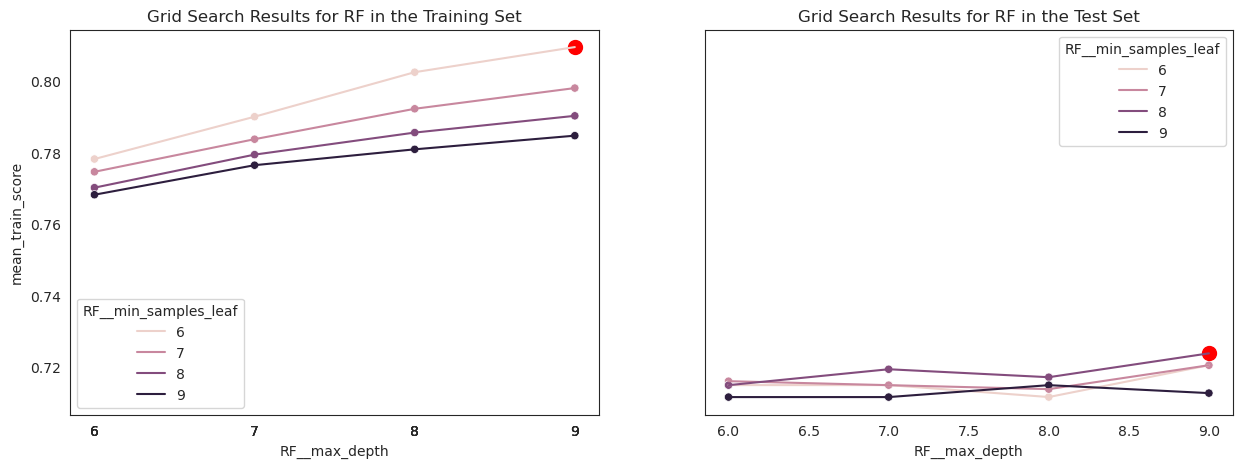

In [37]:
model = RF_gridCV
model_name="RF"
%run -i  "2_5_GridSearch_Plot.py"

In [38]:
RF_inputs = RF_gridCV.best_estimator_['preproc'].get_feature_names_out()

var_importances = pd.DataFrame({'var':RF_inputs, 
                                'importance': model.best_estimator_.named_steps[model_name].feature_importances_}
                                ).sort_values(by="importance", ascending = False)
var_importances

,var,importance
1,num__ap_hi,0.308776
0,num__age,0.284232
4,num__weight,0.150783
2,num__ap_lo,0.132537
3,num__height,0.123672
